In [24]:
#The only thing to include in the paper/presentation from this code is the bar graph
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

random.seed(1000)

In [25]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_2955/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [26]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [27]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [28]:
test_df = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
train_df = pd.read_csv('JORN17_dataset_v1.csv', na_values='?').dropna()
bigtest_df = pd.read_csv('SRER17_pred.csv', na_values='?')
del bigtest_df["Veg_class"]
bigtest_df.dropna()
bigtest_df["Veg_class"] = ""
bigtest_df

,OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
0,1,1,1,14.2,5.04,0.010000,0.053054,0.252378,-0.007871,0.145961,0.234673,0.126273,0.221155,0.400501,0.170450,0.145235,0.234261,0.125838,
1,2,2,2,26.2,5.73,0.016248,0.040314,0.252378,0.043301,0.141544,0.234673,0.135954,0.206992,0.400501,0.207240,0.139659,0.234261,0.134476,
2,3,3,3,10.6,2.29,0.014410,0.111847,0.281741,0.085010,0.167371,0.254378,0.152276,0.274226,0.432882,0.249348,0.167777,0.255698,0.152786,
3,4,4,4,11.0,2.85,0.012281,0.204984,0.310943,0.281741,0.211967,0.254378,0.254378,0.361578,0.438509,0.432882,0.213450,0.255698,0.255698,
4,5,5,5,18.2,3.78,0.012011,0.260015,0.365155,0.256816,0.203891,0.232604,0.209083,0.403924,0.488291,0.410121,0.207537,0.236474,0.212997,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657503,1657605,1657605,1657605,9.4,2.21,0.014932,0.509040,0.536940,0.506748,0.382288,0.407742,0.407359,0.584744,0.606661,0.589247,0.353369,0.377064,0.373630,
1657504,1657606,1657606,1657606,7.2,2.07,1.194732,0.493816,0.545701,0.531150,0.355797,0.390464,0.351225,0.571676,0.602668,0.582336,0.332901,0.363158,0.328131,
1657505,1657607,1657607,1657607,10.2,2.59,0.035261,0.525481,0.641269,0.543615,0.453275,0.507084,0.464525,0.607242,0.687645,0.619722,0.410453,0.451535,0.418655,
1657506,1657608,1657608,1657608,11.8,2.90,0.847143,0.529820,0.610390,0.529278,0.417614,0.479161,0.392868,0.604037,0.665525,0.598336,0.381633,0.430885,0.361104,


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

    testindex8.append(test_index)
    testindex9.append(pred_values)
    
elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.05302141800000015 seconds ---

Accuracy of each fold: 
 [0.7188679245283018, 0.690566037735849, 0.7622641509433963, 0.7452830188679245, 0.7315689981096408]
Avg accuracy: 0.7297100260370226
Std of accuracy : 
0.024312745285325944

[[  53  624]
 [  92 1880]]

              precision    recall  f1-score   support

   non-woody       0.37      0.08      0.13       677
       woody       0.75      0.95      0.84      1972

    accuracy                           0.73      2649
   macro avg       0.56      0.52      0.48      2649
weighted avg       0.65      0.73      0.66      2649

0.07828655834564253
0.9533468559837728
0.36551724137931035
0.12895377128953772


In [7]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 814 1274]
 [ 325 1926]]

              precision    recall  f1-score   support

   non-woody       0.71      0.39      0.50      2088
       woody       0.60      0.86      0.71      2251

    accuracy                           0.63      4339
   macro avg       0.66      0.62      0.61      4339
weighted avg       0.66      0.63      0.61      4339

predicted ['woody' 'woody' 'non-woody' ... 'woody' 'woody' 'woody']
acc 0.6314819082737958
sens  0.8556197245668592
spec  0.38984674329501917
prec  0.7146619841966637
f1_score  0.5044933374651378


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [29]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted

/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
0,1,1,1,14.2,5.04,0.010000,0.053054,0.252378,-0.007871,0.145961,0.234673,0.126273,0.221155,0.400501,0.170450,0.145235,0.234261,0.125838,woody
1,2,2,2,26.2,5.73,0.016248,0.040314,0.252378,0.043301,0.141544,0.234673,0.135954,0.206992,0.400501,0.207240,0.139659,0.234261,0.134476,non-woody
2,3,3,3,10.6,2.29,0.014410,0.111847,0.281741,0.085010,0.167371,0.254378,0.152276,0.274226,0.432882,0.249348,0.167777,0.255698,0.152786,non-woody
3,4,4,4,11.0,2.85,0.012281,0.204984,0.310943,0.281741,0.211967,0.254378,0.254378,0.361578,0.438509,0.432882,0.213450,0.255698,0.255698,woody
4,5,5,5,18.2,3.78,0.012011,0.260015,0.365155,0.256816,0.203891,0.232604,0.209083,0.403924,0.488291,0.410121,0.207537,0.236474,0.212997,woody
5,6,6,6,24.6,5.34,0.011760,0.143938,0.365155,0.159118,0.175792,0.227181,0.187912,0.301899,0.488291,0.313752,0.176406,0.231180,0.189477,woody
6,7,7,7,13.6,2.37,0.011519,0.095585,0.153732,0.090776,0.153697,0.170868,0.159732,0.257637,0.308600,0.257738,0.154285,0.172316,0.160627,non-woody
7,8,8,8,11.2,2.51,0.010956,-0.026384,0.061265,-0.028525,0.106579,0.162647,0.093855,0.143429,0.227148,0.133892,0.104317,0.159023,0.091390,woody
8,9,9,9,20.2,5.49,0.016120,0.037614,0.147766,0.024030,0.133307,0.192798,0.132834,0.201293,0.303233,0.191683,0.131542,0.190033,0.130989,woody
9,10,10,10,9.8,2.83,0.010954,0.074672,0.219833,0.006852,0.149436,0.205513,0.128831,0.237263,0.365430,0.180277,0.148550,0.205168,0.127821,non-woody


In [32]:
bigtest_df.head(n=50)

,OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
0,1,1,1,14.2,5.04,0.010000,0.053054,0.252378,-0.007871,0.145961,0.234673,0.126273,0.221155,0.400501,0.170450,0.145235,0.234261,0.125838,woody
1,2,2,2,26.2,5.73,0.016248,0.040314,0.252378,0.043301,0.141544,0.234673,0.135954,0.206992,0.400501,0.207240,0.139659,0.234261,0.134476,non-woody
2,3,3,3,10.6,2.29,0.014410,0.111847,0.281741,0.085010,0.167371,0.254378,0.152276,0.274226,0.432882,0.249348,0.167777,0.255698,0.152786,non-woody
3,4,4,4,11.0,2.85,0.012281,0.204984,0.310943,0.281741,0.211967,0.254378,0.254378,0.361578,0.438509,0.432882,0.213450,0.255698,0.255698,woody
4,5,5,5,18.2,3.78,0.012011,0.260015,0.365155,0.256816,0.203891,0.232604,0.209083,0.403924,0.488291,0.410121,0.207537,0.236474,0.212997,woody
5,6,6,6,24.6,5.34,0.011760,0.143938,0.365155,0.159118,0.175792,0.227181,0.187912,0.301899,0.488291,0.313752,0.176406,0.231180,0.189477,woody
6,7,7,7,13.6,2.37,0.011519,0.095585,0.153732,0.090776,0.153697,0.170868,0.159732,0.257637,0.308600,0.257738,0.154285,0.172316,0.160627,non-woody
7,8,8,8,11.2,2.51,0.010956,-0.026384,0.061265,-0.028525,0.106579,0.162647,0.093855,0.143429,0.227148,0.133892,0.104317,0.159023,0.091390,woody
8,9,9,9,20.2,5.49,0.016120,0.037614,0.147766,0.024030,0.133307,0.192798,0.132834,0.201293,0.303233,0.191683,0.131542,0.190033,0.130989,woody
9,10,10,10,9.8,2.83,0.010954,0.074672,0.219833,0.006852,0.149436,0.205513,0.128831,0.237263,0.365430,0.180277,0.148550,0.205168,0.127821,non-woody


In [8]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)
woodyarea4 = 0
nonwoodyarea4 = 0
totalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,5):
            for l in testindex9[k]:
                if l == "woody":
                    woodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC4 = woodyarea4/totalarea4 * 100
                    
print(FWC4)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded = woodyarea1/totalarea1 * 100\nprint(needed)\nwoodyarea4 = 0\nnonwoodyarea4 = 0\ntotalarea4 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex9[k]:\n                if l == "woody":\n                    woodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\nelapsed = time

In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 0.31633569600000033 seconds ---

Accuracy of each fold: 
 [0.7283018867924528, 0.7150943396226415, 0.7735849056603774, 0.7566037735849057, 0.7277882797731569]
Avg accuracy: 0.7402746370867068
Std of accuracy : 
0.02149194239791228

[[ 101  576]
 [ 112 1860]]

              precision    recall  f1-score   support

   non-woody       0.47      0.15      0.23       677
       woody       0.76      0.94      0.84      1972

    accuracy                           0.74      2649
   macro avg       0.62      0.55      0.54      2649
weighted avg       0.69      0.74      0.69      2649

0.14918759231905465
0.9432048681541582
0.47417840375586856
0.22696629213483147


In [10]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[1655  433]
 [1181 1070]]

              precision    recall  f1-score   support

   non-woody       0.58      0.79      0.67      2088
       woody       0.71      0.48      0.57      2251

    accuracy                           0.63      4339
   macro avg       0.65      0.63      0.62      4339
weighted avg       0.65      0.63      0.62      4339

predicted ['woody' 'woody' 'non-woody' ... 'woody' 'woody' 'woody']
acc 0.6280248905277713
sens  0.47534429142603285
spec  0.7926245210727969
prec  0.5835684062059239
f1_score  0.6722177091795288


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [30]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted

/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
0,1,1,1,14.2,5.04,0.010000,0.053054,0.252378,-0.007871,0.145961,0.234673,0.126273,0.221155,0.400501,0.170450,0.145235,0.234261,0.125838,woody
1,2,2,2,26.2,5.73,0.016248,0.040314,0.252378,0.043301,0.141544,0.234673,0.135954,0.206992,0.400501,0.207240,0.139659,0.234261,0.134476,non-woody
2,3,3,3,10.6,2.29,0.014410,0.111847,0.281741,0.085010,0.167371,0.254378,0.152276,0.274226,0.432882,0.249348,0.167777,0.255698,0.152786,non-woody
3,4,4,4,11.0,2.85,0.012281,0.204984,0.310943,0.281741,0.211967,0.254378,0.254378,0.361578,0.438509,0.432882,0.213450,0.255698,0.255698,woody
4,5,5,5,18.2,3.78,0.012011,0.260015,0.365155,0.256816,0.203891,0.232604,0.209083,0.403924,0.488291,0.410121,0.207537,0.236474,0.212997,woody
5,6,6,6,24.6,5.34,0.011760,0.143938,0.365155,0.159118,0.175792,0.227181,0.187912,0.301899,0.488291,0.313752,0.176406,0.231180,0.189477,woody
6,7,7,7,13.6,2.37,0.011519,0.095585,0.153732,0.090776,0.153697,0.170868,0.159732,0.257637,0.308600,0.257738,0.154285,0.172316,0.160627,non-woody
7,8,8,8,11.2,2.51,0.010956,-0.026384,0.061265,-0.028525,0.106579,0.162647,0.093855,0.143429,0.227148,0.133892,0.104317,0.159023,0.091390,woody
8,9,9,9,20.2,5.49,0.016120,0.037614,0.147766,0.024030,0.133307,0.192798,0.132834,0.201293,0.303233,0.191683,0.131542,0.190033,0.130989,woody
9,10,10,10,9.8,2.83,0.010954,0.074672,0.219833,0.006852,0.149436,0.205513,0.128831,0.237263,0.365430,0.180277,0.148550,0.205168,0.127821,non-woody


In [33]:
bigtest_df.head(n=50)

,OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
0,1,1,1,14.2,5.04,0.010000,0.053054,0.252378,-0.007871,0.145961,0.234673,0.126273,0.221155,0.400501,0.170450,0.145235,0.234261,0.125838,woody
1,2,2,2,26.2,5.73,0.016248,0.040314,0.252378,0.043301,0.141544,0.234673,0.135954,0.206992,0.400501,0.207240,0.139659,0.234261,0.134476,non-woody
2,3,3,3,10.6,2.29,0.014410,0.111847,0.281741,0.085010,0.167371,0.254378,0.152276,0.274226,0.432882,0.249348,0.167777,0.255698,0.152786,non-woody
3,4,4,4,11.0,2.85,0.012281,0.204984,0.310943,0.281741,0.211967,0.254378,0.254378,0.361578,0.438509,0.432882,0.213450,0.255698,0.255698,woody
4,5,5,5,18.2,3.78,0.012011,0.260015,0.365155,0.256816,0.203891,0.232604,0.209083,0.403924,0.488291,0.410121,0.207537,0.236474,0.212997,woody
5,6,6,6,24.6,5.34,0.011760,0.143938,0.365155,0.159118,0.175792,0.227181,0.187912,0.301899,0.488291,0.313752,0.176406,0.231180,0.189477,woody
6,7,7,7,13.6,2.37,0.011519,0.095585,0.153732,0.090776,0.153697,0.170868,0.159732,0.257637,0.308600,0.257738,0.154285,0.172316,0.160627,non-woody
7,8,8,8,11.2,2.51,0.010956,-0.026384,0.061265,-0.028525,0.106579,0.162647,0.093855,0.143429,0.227148,0.133892,0.104317,0.159023,0.091390,woody
8,9,9,9,20.2,5.49,0.016120,0.037614,0.147766,0.024030,0.133307,0.192798,0.132834,0.201293,0.303233,0.191683,0.131542,0.190033,0.130989,woody
9,10,10,10,9.8,2.83,0.010954,0.074672,0.219833,0.006852,0.149436,0.205513,0.128831,0.237263,0.365430,0.180277,0.148550,0.205168,0.127821,non-woody


In [11]:
"""woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,5):
            for l in testindex2[k]:
                if l == "woody":
                    woodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC = woodyarea1/totalarea1 * 100
                    
print(FWC)"""


'woodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nprint(woodyarea1/totalarea1 * 100)\n\nneeded2 = woodyarea1/totalarea1 * 100\nprint(needed2)\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex2[k]:\n                if l == "woody":\n                    woodyarea1 += test_df.iat[j,4]\n                    totalarea1 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea1 += test_df.iat[j,4]\n                    totalarea1

In [12]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    #makes the list for FWC
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 0.5762139670000002 seconds ---

Accuracy of each fold: 
 [0.6264150943396226, 0.6547169811320754, 0.6245283018867924, 0.5867924528301887, 0.6162570888468809]
Avg accuracy: 0.6217419838071121
Std of accuracy : 
0.021764676736874607

[[ 571  106]
 [ 896 1076]]

              precision    recall  f1-score   support

   non-woody       0.39      0.84      0.53       677
       woody       0.91      0.55      0.68      1972

    accuracy                           0.62      2649
   macro avg       0.65      0.69      0.61      2649
weighted avg       0.78      0.62      0.64      2649

0.843426883308715
0.5456389452332657
0.3892297205180641
0.5326492537313433


In [13]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 595 1493]
 [ 288 1963]]

              precision    recall  f1-score   support

   non-woody       0.67      0.28      0.40      2088
       woody       0.57      0.87      0.69      2251

    accuracy                           0.59      4339
   macro avg       0.62      0.58      0.54      4339
weighted avg       0.62      0.59      0.55      4339

predicted ['woody' 'woody' 'non-woody' ... 'woody' 'woody' 'woody']
acc 0.5895367596220328
sens  0.8720568636161706
spec  0.2849616858237548
prec  0.6738391845979615
f1_score  0.4005385392123864


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [34]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted
bigtest_df.head(n=50)

/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
0,1,1,1,14.2,5.04,0.010000,0.053054,0.252378,-0.007871,0.145961,0.234673,0.126273,0.221155,0.400501,0.170450,0.145235,0.234261,0.125838,woody
1,2,2,2,26.2,5.73,0.016248,0.040314,0.252378,0.043301,0.141544,0.234673,0.135954,0.206992,0.400501,0.207240,0.139659,0.234261,0.134476,non-woody
2,3,3,3,10.6,2.29,0.014410,0.111847,0.281741,0.085010,0.167371,0.254378,0.152276,0.274226,0.432882,0.249348,0.167777,0.255698,0.152786,non-woody
3,4,4,4,11.0,2.85,0.012281,0.204984,0.310943,0.281741,0.211967,0.254378,0.254378,0.361578,0.438509,0.432882,0.213450,0.255698,0.255698,woody
4,5,5,5,18.2,3.78,0.012011,0.260015,0.365155,0.256816,0.203891,0.232604,0.209083,0.403924,0.488291,0.410121,0.207537,0.236474,0.212997,woody
5,6,6,6,24.6,5.34,0.011760,0.143938,0.365155,0.159118,0.175792,0.227181,0.187912,0.301899,0.488291,0.313752,0.176406,0.231180,0.189477,woody
6,7,7,7,13.6,2.37,0.011519,0.095585,0.153732,0.090776,0.153697,0.170868,0.159732,0.257637,0.308600,0.257738,0.154285,0.172316,0.160627,non-woody
7,8,8,8,11.2,2.51,0.010956,-0.026384,0.061265,-0.028525,0.106579,0.162647,0.093855,0.143429,0.227148,0.133892,0.104317,0.159023,0.091390,woody
8,9,9,9,20.2,5.49,0.016120,0.037614,0.147766,0.024030,0.133307,0.192798,0.132834,0.201293,0.303233,0.191683,0.131542,0.190033,0.130989,woody
9,10,10,10,9.8,2.83,0.010954,0.074672,0.219833,0.006852,0.149436,0.205513,0.128831,0.237263,0.365430,0.180277,0.148550,0.205168,0.127821,non-woody


In [14]:

"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)
woodyarea2 = 0
nonwoodyarea2 = 0
totalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,5):
            for l in testindex4[k]:
                if l == "woody":
                    woodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC2 = woodyarea2/totalarea2 * 100
                    
print(FWC2)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded3 = woodyarea1/totalarea1 * 100\nprint(needed3)\nwoodyarea2 = 0\nnonwoodyarea2 = 0\ntotalarea2 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex4[k]:\n                if l == "woody":\n                    woodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\nelapsed = time

#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [15]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.73773585 0.70377358 0.71698113 0.72075472 0.7221172 ]

Avg accuracy: 0.7202724970574599

K=2

Accuracy of each fold: 
 [0.66415094 0.68113208 0.66981132 0.64716981 0.66162571]

Avg accuracy: 0.6647779719656168

K=3

Accuracy of each fold: 
 [0.73207547 0.73018868 0.74716981 0.72641509 0.72589792]

Avg accuracy: 0.7323493954417376

K=4

Accuracy of each fold: 
 [0.72264151 0.72830189 0.72264151 0.71509434 0.69754253]

Avg accuracy: 0.7172443556728607

K=5

Accuracy of each fold: 
 [0.74339623 0.74528302 0.77358491 0.73584906 0.72967864]

Avg accuracy: 0.7455583692977137

K=6

Accuracy of each fold: 
 [0.71509434 0.71886792 0.75849057 0.73396226 0.71644612]

Avg accuracy: 0.7285722438206654

K=7

Accuracy of each fold: 
 [0.76603774 0.73962264 0.7754717  0.74528302 0.75425331]

Avg accuracy: 0.7561336804936334

K=8

Accuracy of each fold: 
 [0.74339623 0.73207547 0.7490566  0.72830189 0.73534972]

Avg accuracy: 0.737635981025074

K=9

Accuracy of each fol

In [16]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)


elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 2.2164446820000006 seconds ---

Accuracy of each fold: 
 [0.7547169811320755, 0.7396226415094339, 0.779245283018868, 0.7566037735849057, 0.7561436672967864]
Avg accuracy: 0.7572664693084139
Std of accuracy : 
0.01266943291121953

[[ 256  421]
 [ 222 1750]]

              precision    recall  f1-score   support

   non-woody       0.54      0.38      0.44       677
       woody       0.81      0.89      0.84      1972

    accuracy                           0.76      2649
   macro avg       0.67      0.63      0.64      2649
weighted avg       0.74      0.76      0.74      2649

0.37813884785819796
0.8874239350912779
0.5355648535564853
0.4432900432900433


In [17]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


[[ 818 1270]
 [ 587 1664]]

              precision    recall  f1-score   support

   non-woody       0.58      0.39      0.47      2088
       woody       0.57      0.74      0.64      2251

    accuracy                           0.57      4339
   macro avg       0.57      0.57      0.56      4339
weighted avg       0.57      0.57      0.56      4339

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.5720212030421756
sens  0.739227010217681
spec  0.39176245210727967
prec  0.5822064056939502
f1_score  0.4683653020326367


In [35]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted
bigtest_df.head(n=50)

/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
0,1,1,1,14.2,5.04,0.010000,0.053054,0.252378,-0.007871,0.145961,0.234673,0.126273,0.221155,0.400501,0.170450,0.145235,0.234261,0.125838,woody
1,2,2,2,26.2,5.73,0.016248,0.040314,0.252378,0.043301,0.141544,0.234673,0.135954,0.206992,0.400501,0.207240,0.139659,0.234261,0.134476,non-woody
2,3,3,3,10.6,2.29,0.014410,0.111847,0.281741,0.085010,0.167371,0.254378,0.152276,0.274226,0.432882,0.249348,0.167777,0.255698,0.152786,non-woody
3,4,4,4,11.0,2.85,0.012281,0.204984,0.310943,0.281741,0.211967,0.254378,0.254378,0.361578,0.438509,0.432882,0.213450,0.255698,0.255698,woody
4,5,5,5,18.2,3.78,0.012011,0.260015,0.365155,0.256816,0.203891,0.232604,0.209083,0.403924,0.488291,0.410121,0.207537,0.236474,0.212997,woody
5,6,6,6,24.6,5.34,0.011760,0.143938,0.365155,0.159118,0.175792,0.227181,0.187912,0.301899,0.488291,0.313752,0.176406,0.231180,0.189477,woody
6,7,7,7,13.6,2.37,0.011519,0.095585,0.153732,0.090776,0.153697,0.170868,0.159732,0.257637,0.308600,0.257738,0.154285,0.172316,0.160627,non-woody
7,8,8,8,11.2,2.51,0.010956,-0.026384,0.061265,-0.028525,0.106579,0.162647,0.093855,0.143429,0.227148,0.133892,0.104317,0.159023,0.091390,woody
8,9,9,9,20.2,5.49,0.016120,0.037614,0.147766,0.024030,0.133307,0.192798,0.132834,0.201293,0.303233,0.191683,0.131542,0.190033,0.130989,woody
9,10,10,10,9.8,2.83,0.010954,0.074672,0.219833,0.006852,0.149436,0.205513,0.128831,0.237263,0.365430,0.180277,0.148550,0.205168,0.127821,non-woody


In [18]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)
woodyarea3 = 0
nonwoodyarea3 = 0
totalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,5):
            for l in testindex6[k]:
                if l == "woody":
                    woodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC3 = woodyarea3/totalarea3 * 100
                    
print(FWC3)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded4 = woodyarea1/totalarea1 * 100\nprint(needed4)\nwoodyarea3 = 0\nnonwoodyarea3 = 0\ntotalarea3 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex6[k]:\n                if l == "woody":\n                    woodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n\nelapsed = 

In [19]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.729710,0.024313,0.078287,0.953347,0.365517,0.128954,0.053021
LDA,0.740275,0.021492,0.149188,0.943205,0.474178,0.226966,0.316336
QDA,0.621742,0.021765,0.843427,0.545639,0.389230,0.532649,0.576214
KNN-CV,0.757266,0.012669,0.378139,0.887424,0.535565,0.443290,2.216445


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7297100260370226, 0.7402746370867068, 0.6217419838071121, 0.7572664693084139]
Sen[0.07828655834564253, 0.14918759231905465, 0.843426883308715, 0.37813884785819796]
Spec[0.9533468559837728, 0.9432048681541582, 0.5456389452332657, 0.8874239350912779]
P[0.36551724137931035, 0.47417840375586856, 0.3892297205180641, 0.5355648535564853]
F1[0.12895377128953772, 0.22696629213483147, 0.5326492537313433, 0.4432900432900433]


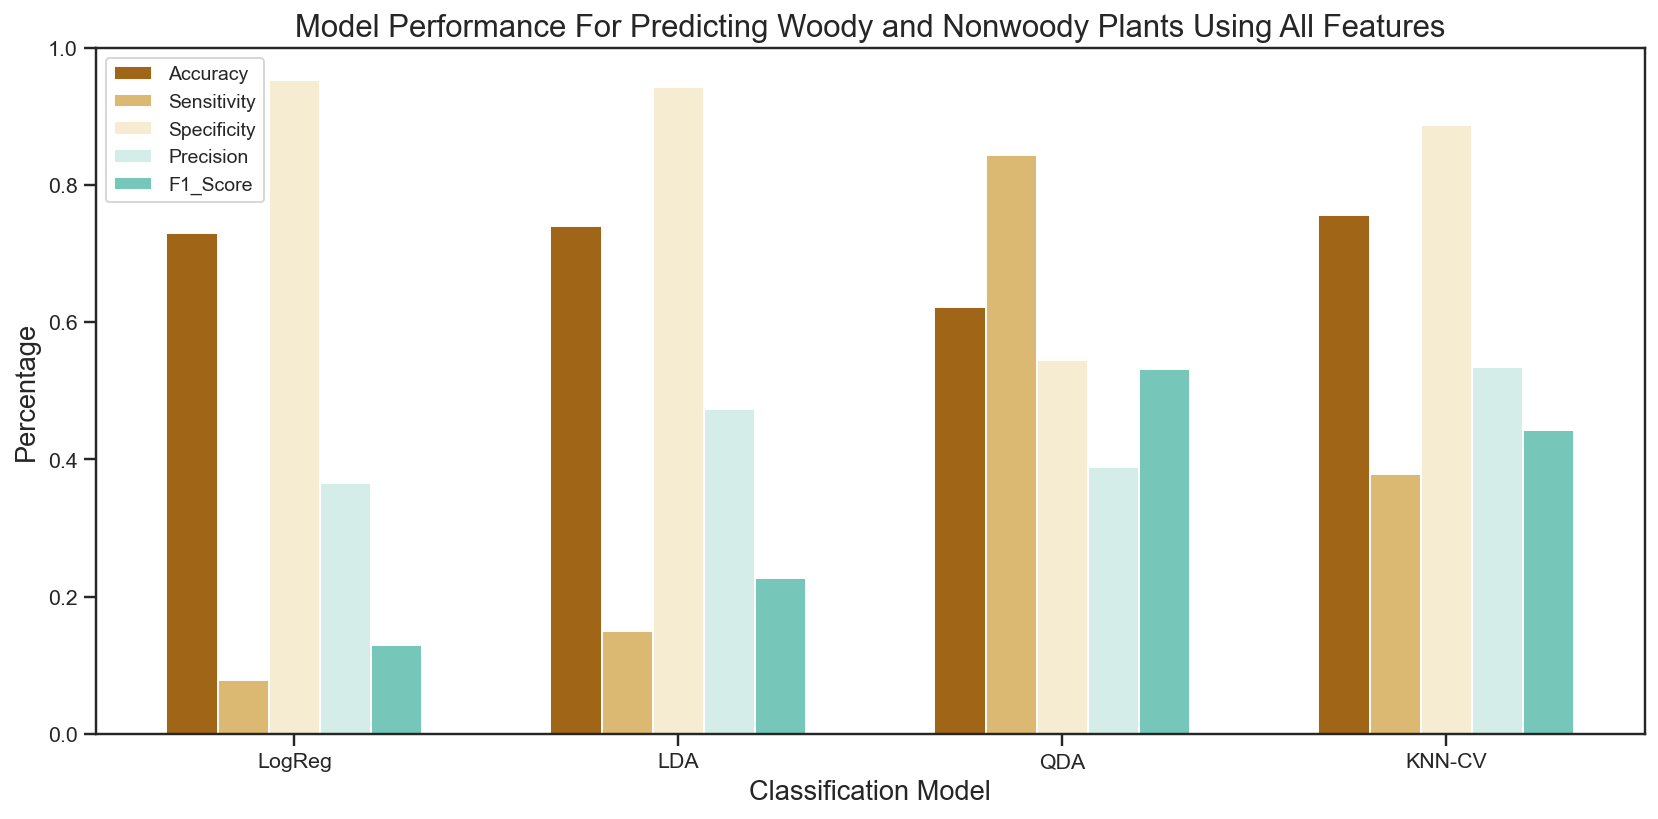

In [20]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

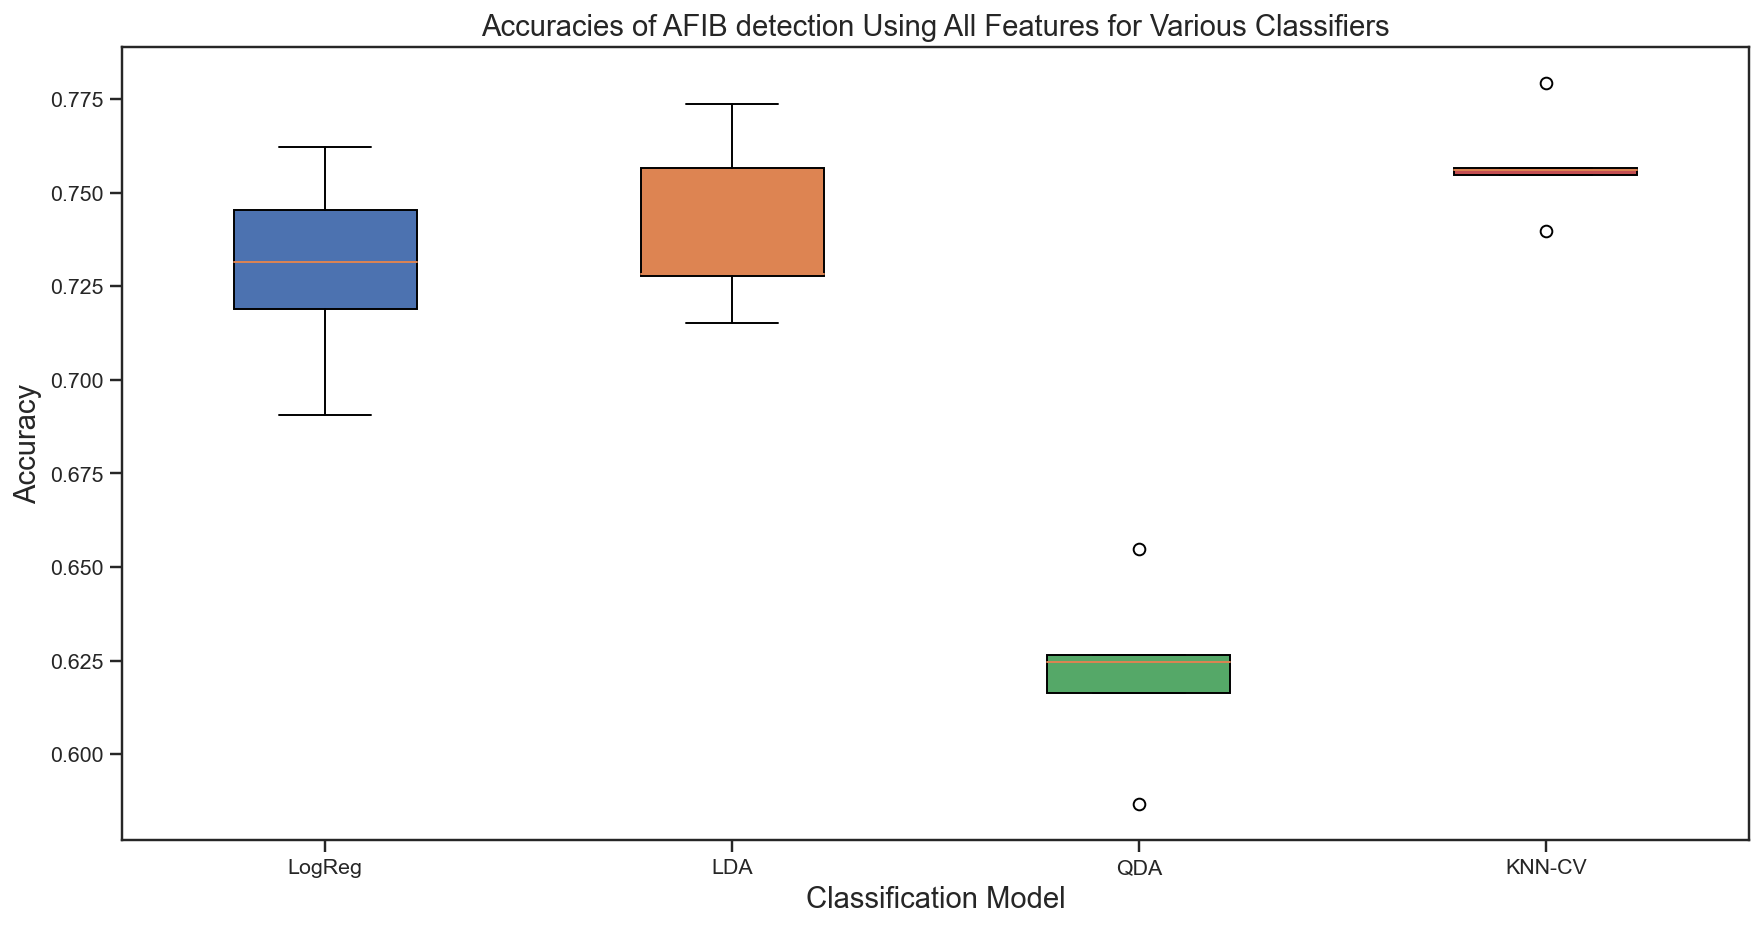

In [21]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [22]:
"""
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(FWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWC3))
"""

'\nprint("Log reg act: " + str(needed))\nprint("Log reg pred: " + str(FWC4))\nprint("QDA act: " + str(needed2))\nprint("QDA pred: " + str(FWC2))\nprint("LDA act: " + str(needed3))\nprint("LDA pred: " + str(FWC))\nprint("KNN act: " + str(needed4))\nprint("KNN pred: " +str(FWC3))\n'